<a href="https://colab.research.google.com/github/rounak-data/Customer-Lifetime-Value-CLV-Prediction/blob/main/clv_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload()



Saving ecommerce_data.csv to ecommerce_data (1).csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set display options
pd.set_option('display.max_columns', None)
# Load the ecommerce dataset
df = pd.read_csv('ecommerce_data.csv')
df.head()

# Shape and data types
print(df.shape)
print(df.dtypes)

# Check for null values
df.isnull().sum()

# Summary statistics
df.describe()

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check the range of dates
print("Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

# TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# View result
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()

# Filter out invalid entries
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Recheck
df.describe()

print("Unique customers:", df['CustomerID'].nunique())
print("Unique invoices:", df['InvoiceNo'].nunique())

(500, 6)
InvoiceNo       object
CustomerID      object
InvoiceDate     object
Quantity         int64
UnitPrice      float64
Country         object
dtype: object
Date range: 2024-04-11 00:00:00 to 2025-04-10 00:00:00
Unique customers: 50
Unique invoices: 500


In [8]:
# Reference date for Recency calculation (day after last transaction)
today = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Analysis Date:", today.date())


Analysis Date: 2025-04-11


In [9]:
# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today - x.max()).days,      # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview RFM table
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,C1000,33,13,2347.46
1,C1001,38,11,3828.35
2,C1002,17,14,3586.85
3,C1003,4,4,377.41
4,C1004,8,8,2694.78


In [10]:
# Descriptive stats for RFM
rfm.describe()


,Recency,Frequency,Monetary
count,50.000000,50.00000,50.000000
mean,32.600000,10.00000,2846.998000
std,33.753004,3.60272,1262.206523
min,1.000000,3.00000,261.230000
25%,11.000000,7.25000,1910.827500
50%,26.000000,9.00000,2693.660000
75%,41.000000,13.00000,3843.207500
max,205.000000,18.00000,5228.150000


In [11]:
# Score each RFM metric (1 = low, 5 = high)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine scores to form an RFM Segment
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Optional: create an RFM Score (total of the 3)
rfm['RFM_Score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

# View top customers
rfm.sort_values(by='RFM_Score', ascending=False).head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
17,C1017,8,18,5024.27,5,5,5,555,15
25,C1025,1,14,3614.47,5,5,4,554,14
28,C1028,14,15,4396.42,4,5,5,455,14
46,C1046,16,17,4270.18,4,5,5,455,14
5,C1005,27,16,5228.15,3,5,5,355,13


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [13]:
# Features and target
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [15]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", round(mse, 2))
print("R-squared Score:", round(r2, 2))


Mean Squared Error: 539683.79
R-squared Score: 0.59


In [16]:
# Predict CLV for everyone
rfm['Predicted_CLV'] = model.predict(rfm[['Recency', 'Frequency']])

# View top predicted CLVs
rfm.sort_values('Predicted_CLV', ascending=False).head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score,Predicted_CLV
17,C1017,8,18,5024.27,5,5,5,555,15,5379.255014
46,C1046,16,17,4270.18,4,5,5,455,14,5078.310458
5,C1005,27,16,5228.15,3,5,5,355,13,4785.428332
49,C1049,14,16,4106.33,4,5,4,454,13,4750.491142
29,C1029,36,15,4990.95,2,5,5,255,12,4487.171253


In [17]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00


In [18]:
from lifetimes.utils import summary_data_from_transaction_data

# Prepare data (CustomerID, InvoiceDate, MonetaryValue)
lifetimes_df = summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=df['InvoiceDate'].max()
)

lifetimes_df.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
C1000,12.0,330.0,362.0,161.341667
C1001,10.0,326.0,363.0,337.073000
C1002,13.0,308.0,324.0,253.104615
C1003,3.0,359.0,362.0,115.973333
C1004,7.0,321.0,328.0,342.545714


In [19]:
# Customers with frequency > 0 are eligible for monetary model
lifetimes_df = lifetimes_df[lifetimes_df['frequency'] > 0]


In [20]:
from lifetimes import BetaGeoFitter

# Fit the model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    lifetimes_df['frequency'],
    lifetimes_df['recency'],
    lifetimes_df['T']
)

# Predict purchases for next 90 days
lifetimes_df['predicted_purchases_90d'] = bgf.predict(90, lifetimes_df['frequency'], lifetimes_df['recency'], lifetimes_df['T'])
lifetimes_df.head()


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,predicted_purchases_90d
CustomerID,,,,,
C1000,12.0,330.0,362.0,161.341667,2.731706
C1001,10.0,326.0,363.0,337.073000,2.448609
C1002,13.0,308.0,324.0,253.104615,3.051266
C1003,3.0,359.0,362.0,115.973333,1.474865
C1004,7.0,321.0,328.0,342.545714,2.146714


In [21]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
    lifetimes_df['frequency'],
    lifetimes_df['monetary_value']
)

# Estimate average transaction value
lifetimes_df['expected_avg_value'] = ggf.conditional_expected_average_profit(
    lifetimes_df['frequency'],
    lifetimes_df['monetary_value']
)


In [22]:
# Predict CLV over 90 days
lifetimes_df['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    lifetimes_df['frequency'],
    lifetimes_df['recency'],
    lifetimes_df['T'],
    lifetimes_df['monetary_value'],
    time=3,      # 3 months
    discount_rate=0.01
)

# View top customers by CLV
lifetimes_df.sort_values('predicted_clv', ascending=False).head()


,frequency,recency,T,monetary_value,predicted_purchases_90d,expected_avg_value,predicted_clv
CustomerID,,,,,,,
C1040,12.0,255.0,288.0,360.171667,3.086054,360.918057,1091.902154
C1023,9.0,331.0,346.0,464.504444,2.371638,465.331669,1081.888912
C1031,12.0,326.0,343.0,379.915000,2.814687,380.637599,1050.299946
C1005,15.0,325.0,351.0,329.699333,3.205362,330.325972,1037.985848
C1042,12.0,324.0,360.0,381.340000,2.740209,382.060882,1026.332125


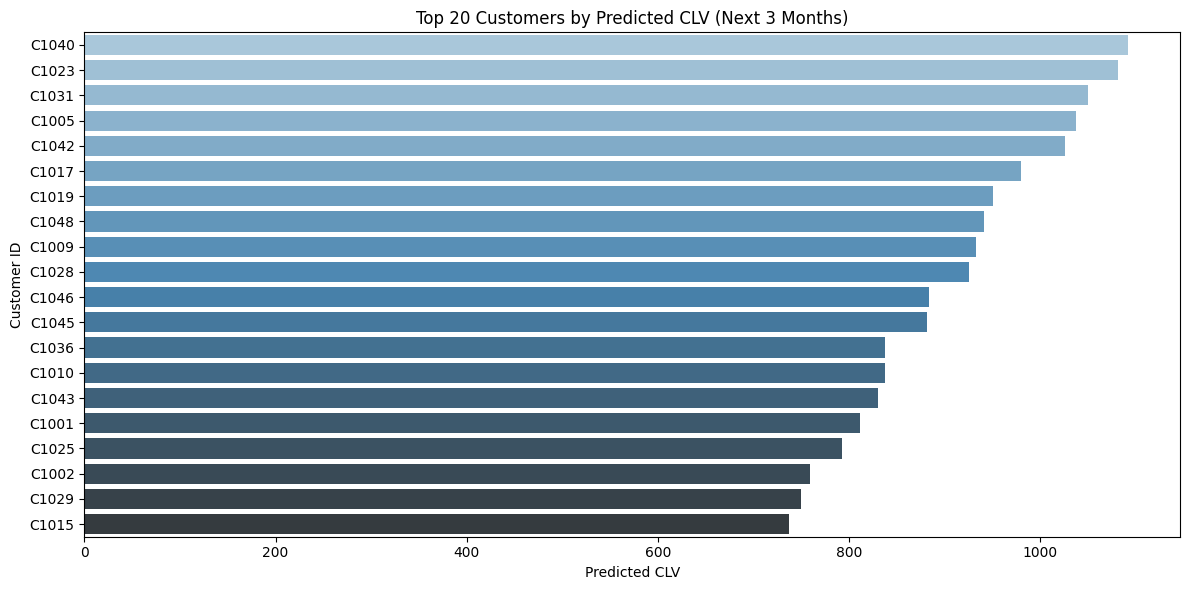

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by predicted CLV
top_customers = lifetimes_df.sort_values('predicted_clv', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=top_customers, x='predicted_clv', y=top_customers.index, palette='Blues_d')
plt.title('Top 20 Customers by Predicted CLV (Next 3 Months)')
plt.xlabel('Predicted CLV')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


In [24]:
# Save predicted CLV table
lifetimes_df.to_csv("predicted_clv_output.csv")
